In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.parser import parse
import ipywidgets as widgets
from copy import deepcopy
from tqdm import tqdm
import imageio
from IPython import display
import plotly.graph_objects as go
import itertools

In [3]:
# Enter your parameters here
ASSET_NAME = 'bitcoin'
START_DATE = datetime(2017, 1, 1) # time period for analysis
END_DATE = datetime.now()
BUFFER = timedelta(days=100) # buffer before to pre-calculate SMA/EMA, best to set to max window
INVESTMENT = 1 # in $
FEES = 0.0025 # in %
SLIPPAGE_FACTOR = 0.25 # in % of high-low
SEED = 42

In [4]:
def download_coin_history(asset_name, start_date, end_date):
    from bs4 import BeautifulSoup
    import requests
    
    # Download data
    start_date = start_date.strftime('%Y%m%d') # Bitcoin is the oldest
    end_date = end_date.strftime('%Y%m%d')
    url = f"https://coinmarketcap.com/currencies/{asset_name}/historical-data/?start={start_date}&end={end_date}"
    user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36"
    content = requests.get(url, headers={'User-Agent': user_agent}).content
    
    # Parse data
    soup = BeautifulSoup(content, 'html.parser')
    data = [[td.text.strip() 
             for td in tr.findChildren('td')] 
            for tr in soup.tbody.findChildren('tr')]
    df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', drop=True, inplace=True)
    df.sort_index(inplace=True)
    df = df.apply(lambda x: pd.to_numeric(x.str.replace(",", "").str.replace("-", "")), axis=0)
    return df

In [5]:
# df with buffer
df_buf = download_coin_history(ASSET_NAME, START_DATE-BUFFER, END_DATE)

print(df_buf.shape)

(1247, 6)


In [6]:
# df for analysis
wo_buffer_mask = (df_buf.index >= START_DATE) & (df_buf.index <= END_DATE) # mask without buffer

df = df_buf.loc[wo_buffer_mask, :]

print(df.shape)

(1147, 6)


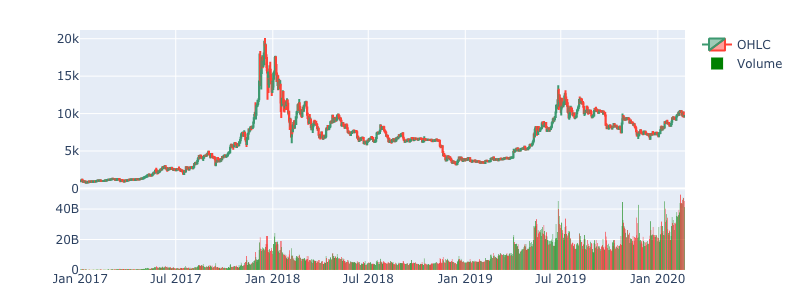

In [7]:
# OHLCV class is for convenience to check and plot the OHLC data
ohlcv_buf = vbt.OHLCV.from_df(df_buf)
ohlcv = vbt.OHLCV.from_df(df)

ohlcv.plot(index=df.index)

## Single test

Perform a single test to see how our DMAC strategy compares to the hold strategy.

In [8]:
FAST_WINDOW = 10
SLOW_WINDOW = 22

In [9]:
# Pre-calculate running windows on data with time buffer
dmac = vbt.DMAC(ohlcv_buf.open, FAST_WINDOW, SLOW_WINDOW)

print(dmac.fast.shape, dmac.slow.shape)

(1247, 1) (1247, 1)


In [10]:
# Remove the time buffer
dmac.fast = dmac.fast[wo_buffer_mask, :]
dmac.slow = dmac.slow[wo_buffer_mask, :]

print(dmac.fast.shape, dmac.slow.shape)

(1147, 1) (1147, 1)


In [11]:
entries, exits = dmac.crossover_signals()

print(entries.shape, exits.shape)

(1147, 1) (1147, 1)


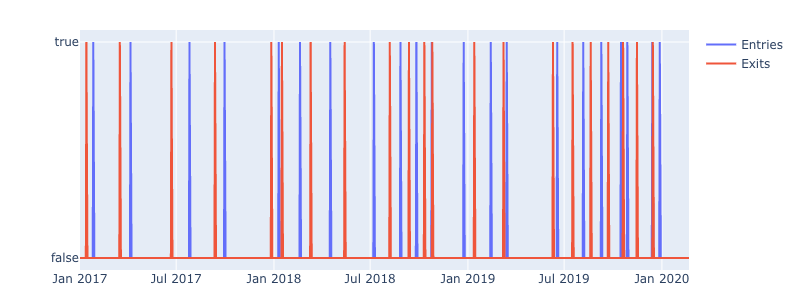

In [12]:
fig = entries.plot(index=df.index, label='Entries', return_fig=True)
exits.plot(index=df.index, label='Exits', fig=fig)

(1147, 1)


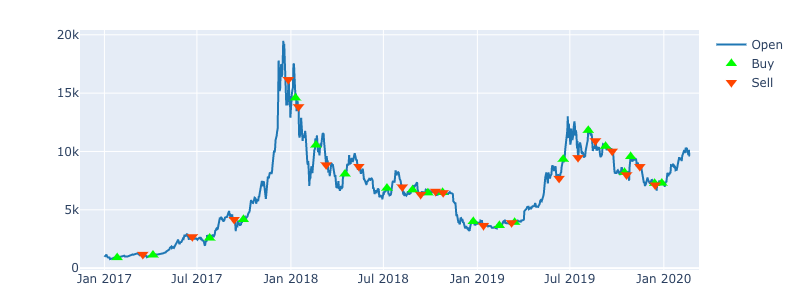

In [13]:
# Make positions based on signals, with 1 being "buy" and -1 being "sell"
positions = vbt.Positions.from_signals(entries, exits)

print(positions.shape)
positions.plot(ohlcv.open, index=df.index, label='Open') # add return_fig=True for interactivity

In [14]:
# Make slippage depending on day's high and low
# Shift both by one to avoid look ahead bias
slippage = (ohlcv_buf.high.fshift(1) - ohlcv_buf.low.fshift(1)) * SLIPPAGE_FACTOR / ohlcv_buf.open
slippage = slippage[wo_buffer_mask, :]

print(slippage.shape)

(1147, 1)


In [15]:
# Build partfolio, which internally calculates the equity curve
portfolio = vbt.Portfolio(ohlcv.open, positions, investment=INVESTMENT, fees=FEES, slippage=slippage)
portfolio

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:128: RuntimeWarning:

invalid value encountered in less_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:134: RuntimeWarning:

invalid value encountered in greater_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:176: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:180: RuntimeWarning:

invalid value encountered in less



                          0
num_trades        21.000000
total_net_profit  17.454815
avg_win            3.241005
avg_loss           1.054079
win_prob           0.476190
loss_prob          0.523810
appt               0.991199
mdd                0.542838

In [16]:
# Now build portfolio for a "Hold" strategy
# Here we buy once at the beginning and never sell
hold_entries = vbt.Signals.falses(ohlcv.open.shape)
hold_entries[0, :] = True
hold_exits = vbt.Signals.falses(ohlcv.open.shape)
hold_positions = vbt.Positions.from_signals(hold_entries, hold_exits)
hold_portfolio = vbt.Portfolio(ohlcv.open, hold_positions, investment=INVESTMENT, fees=FEES, slippage=slippage)
hold_portfolio

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:157: RuntimeWarning:

Mean of empty slice



                         0
num_trades        1.000000
total_net_profit  8.906720
avg_win           8.913490
avg_loss          0.000000
win_prob          1.000000
loss_prob         0.000000
appt              8.913490
mdd               0.833831

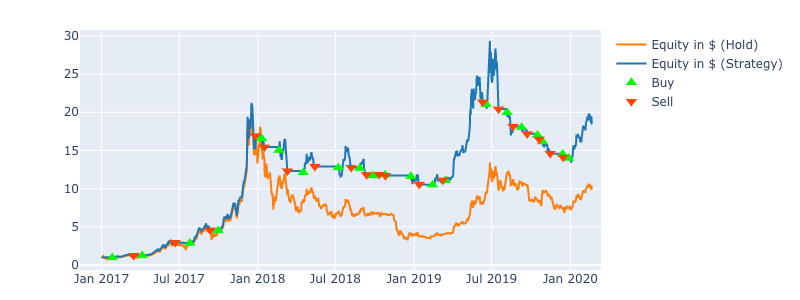

In [17]:
# Equity in dollars
fig = portfolio.equity.plot(label='Equity in $ (Strategy)', 
                            benchmark=hold_portfolio.equity, 
                            benchmark_label='Equity in $ (Hold)',
                            index=df.index, 
                            return_fig=True)
positions.plot(portfolio.equity, plot_ts=False, index=df.index, fig=fig)

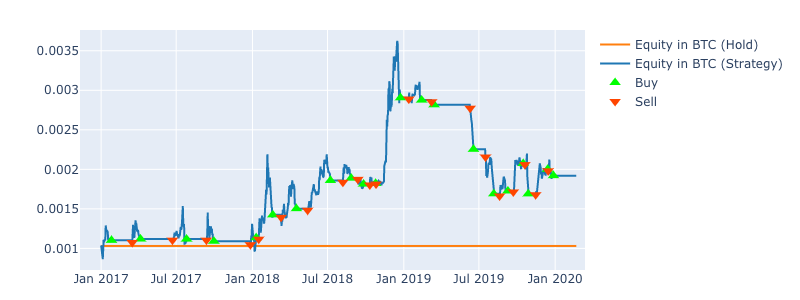

In [18]:
# Equity in Bitcoins
fig = portfolio.equity_in_shares.plot(label='Equity in BTC (Strategy)', 
                                      benchmark=hold_portfolio.equity_in_shares, 
                                      benchmark_label='Equity in BTC (Hold)',
                                      index=df.index, 
                                      return_fig=True)
positions.plot(portfolio.equity_in_shares, plot_ts=False, index=df.index, fig=fig)

## Slider of window combinations

Implement an interactive window slider to easily compare windows by their performance.

In [19]:
MIN_WINDOW = 2
MAX_WINDOW = 100

In [20]:
def portfolio_from_windows(fast_window, slow_window):
    """Getting fast and slow window, calculate the performance."""
    # Basically the same as we did above
    dmac = vbt.DMAC(ohlcv_buf.open, fast_window, slow_window)
    dmac.fast, dmac.slow = dmac.fast[wo_buffer_mask, :], dmac.slow[wo_buffer_mask, :]
    entries, exits = dmac.crossover_signals()
    positions = vbt.Positions.from_signals(entries, exits)
    portfolio = vbt.Portfolio(ohlcv.open, positions, investment=INVESTMENT, fees=FEES, slippage=slippage)
    return portfolio

portfolio_from_windows(10, 22)

                          0
num_trades        21.000000
total_net_profit  17.454815
avg_win            3.241005
avg_loss           1.054079
win_prob           0.476190
loss_prob          0.523810
appt               0.991199
mdd                0.542838

In [21]:
windows_slider = widgets.IntRangeSlider(
    value=[10, 22],
    min=MIN_WINDOW,
    max=MAX_WINDOW,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)
df_html = widgets.HTML()

def on_value_change(value):
    portfolio = portfolio_from_windows(*value['new'])
    df_html.value = portfolio.key_metrics_df.to_html()
    
windows_slider.observe(on_value_change, names='value')
on_value_change({'new': windows_slider.value})

widgets.VBox([
    widgets.HBox([widgets.Label('Fast and slow window:'), windows_slider]), 
    df_html
])

In [22]:
widgets.Widget.close_all() # after using, release memory and notebook metadata

## Window combinations as a heatmap

Calculate the performance of each window combination and display the results as a heatmap.

In [23]:
METRIC = 'total_net_profit'

In [24]:
wrange = np.arange(MIN_WINDOW, MAX_WINDOW+1)

print(wrange.shape)

(99,)


In [25]:
comb = itertools.combinations(np.arange(len(wrange)), 2) # twice less params
fast_idxs, slow_idxs = np.asarray(list(comb)).transpose()
fast_windows, slow_windows = wrange[fast_idxs], wrange[slow_idxs]

# 99 x 99 = 4851
print(fast_windows.shape, slow_windows.shape)

(4851,) (4851,)


In [26]:
# Look at Tests.py, DMAC can take fast and slow windows both as single values or as arrays!
dmac_comb = vbt.DMAC(ohlcv_buf.open, fast_windows, slow_windows)

print(dmac_comb.fast.shape, dmac_comb.slow.shape)

(1247, 4851) (1247, 4851)


In [27]:
# Remove the time buffer
dmac_comb.fast = dmac_comb.fast[wo_buffer_mask, :]
dmac_comb.slow = dmac_comb.slow[wo_buffer_mask, :]

# The reason for having the time buffer was to avoid NaNs
# After removing it, our data should have none nulls
assert(~np.isnan(dmac_comb.fast).any())
assert(~np.isnan(dmac_comb.slow).any())

print(dmac_comb.fast.shape, dmac_comb.slow.shape)

(1147, 4851) (1147, 4851)


In [28]:
# We perform the same steps, but now we have 4851 columns instead of 1
# Each column corresponds to a pair of fast and slow windows
entries_comb, exits_comb = dmac_comb.crossover_signals()

print(entries_comb.shape, exits_comb.shape)

(1147, 4851) (1147, 4851)


In [29]:
positions_comb = vbt.Positions.from_signals(entries_comb, exits_comb)

print(positions_comb.shape)

(1147, 4851)


In [30]:
portfolio_comb = vbt.Portfolio(ohlcv.open, positions_comb, investment=INVESTMENT, fees=FEES, slippage=slippage)

In [31]:
strat_comb = getattr(portfolio_comb, METRIC)

print(strat_comb.shape)

(4851,)


In [32]:
def unstack_comb(comb, symmetric=True):
    """Unstack the array into a matrix of shape (wrange, wrange)."""
    metric_matrix = np.full((wrange.shape[0], wrange.shape[0]), np.nan)
    metric_matrix[fast_idxs, slow_idxs] = comb
    if symmetric:
        metric_matrix[slow_idxs, fast_idxs] = comb # symmetric
    return metric_matrix

# Convert this array into a matrix of shape (99, 99): 99 fast windows x 99 slow windows
strat_matrix = unstack_comb(strat_comb)

print(strat_matrix.shape)

(99, 99)


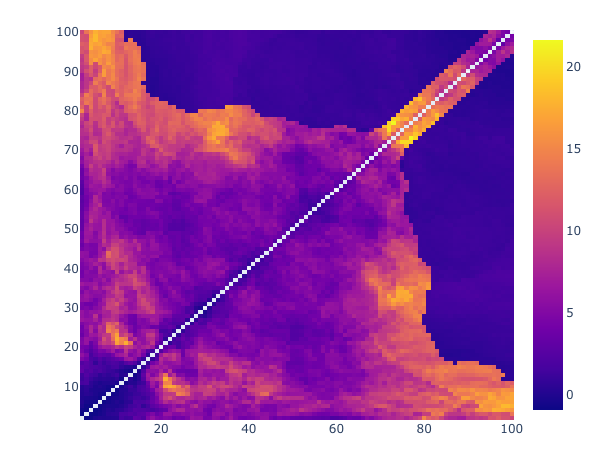

In [33]:
vbt.Heatmap(wrange, wrange, data=strat_matrix, figsize=(600, 450)).show_png()  # remove show_png() for interactivity

In [34]:
min_idx, max_idx = np.unravel_index(np.nanargmax(strat_matrix), strat_matrix.shape)

print(wrange[min_idx], wrange[max_idx]) # your optimal params

73 77


## Heatmap filtered by time range

Implement an interactive date range slider to easily compare heatmaps over time.

In [35]:
TS_SIZE = (750, 250)
HEATMAP_SIZE = (650, 450)
METRIC = 'roi'

In [36]:
def metric_matrix_from_comb_signals(entries_comb, exits_comb, metric, mask=slice(None)):
    """Calculate the performance matrix from signal matrices."""
    positions_comb = vbt.Positions.from_signals(entries_comb, exits_comb)
    portfolio_comb = vbt.Portfolio(
        ohlcv.open[mask, :], 
        positions_comb, 
        investment=INVESTMENT, 
        fees=FEES, 
        slippage=slippage[mask, :])
    metric_comb = getattr(portfolio_comb, metric)
    metric_matrix = unstack_comb(metric_comb)
    return metric_matrix

metric_matrix_from_comb_signals(entries_comb, exits_comb, METRIC).shape

(99, 99)

In [37]:
def metric_matrix_from_date_range(from_date, to_date, metric, dmac_comb=dmac_comb):
    """Calculate the performance matrix for a date range."""
    range_mask = (df.index >= from_date) & (df.index <= to_date)
    dmac_comb = deepcopy(dmac_comb) # use pre-calculated windows
    dmac_comb.fast, dmac_comb.slow = dmac_comb.fast[range_mask, :], dmac_comb.slow[range_mask, :]
    entries_comb, exits_comb = dmac_comb.crossover_signals()
    metric_matrix = metric_matrix_from_comb_signals(entries_comb, exits_comb, metric, mask=range_mask)
    return metric_matrix

metric_matrix_from_date_range(str(df.index[0]), str(df.index[-1]), METRIC).shape

(99, 99)

In [38]:
def hold_metric_from_date_range(from_date, to_date, metric):
    """Calculate the performance matrix for a date range and holding strategy."""
    range_mask = (df.index >= from_date) & (df.index <= to_date)
    hold_entries = vbt.Signals.falses(ohlcv.open[range_mask, :].shape)
    hold_entries[0, :] = True
    hold_exits = vbt.Signals.falses(ohlcv.open[range_mask, :].shape)
    hold_positions = vbt.Positions.from_signals(hold_entries, hold_exits)
    hold_portfolio = vbt.Portfolio(ohlcv.open[range_mask, :],
                               hold_positions, 
                               investment=INVESTMENT, 
                               fees=FEES, 
                               slippage=slippage[range_mask, :])
    return getattr(hold_portfolio, metric)[0]

hold_metric_from_date_range(str(df.index[0]), str(df.index[-1]), METRIC)

8.906719852205262

In [39]:
# Date range slider
selection_range_slider = widgets.SelectionRangeSlider(
    options=df.index,
    index=(0, len(df.index)-1),
    orientation='horizontal',
    layout={'width': '500px'},
    continuous_update=False,
    readout=False
)
date_range_label = widgets.Label()

# TimeSeries image
ts_fig = ohlcv.plot(
    index=df.index, 
    return_fig=True, 
    layout_kwargs=dict(title='Bitcoin 24H Price', annotations=[
            go.layout.Annotation(
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=0.5,
                y=0.9,
                font=dict(size=14),
                bordercolor='black',
                borderwidth=1,
                bgcolor='white'
            )
        ]), 
    figsize=TS_SIZE)
ts_img = widgets.Image(
    format='png',
    width=TS_SIZE[0],
    height=TS_SIZE[1],
)

# Heatmap image
heatmap_fig = vbt.Heatmap(
    wrange, 
    wrange, 
    heatmap_kwargs=dict(colorbar=dict(tickformat='%', ticks="outside"), colorscale='RdBu'), 
    layout_kwargs=dict(title='ROI of DMAC Strategy', xaxis_title='SMA window', yaxis_title='SMA window'), 
    figsize=HEATMAP_SIZE
)
heatmap_img = widgets.Image(
    format='png',
    width=HEATMAP_SIZE[0],
    height=HEATMAP_SIZE[1],
)

def update_figs(from_date, to_date):
    """Update figures with new data."""
    metric_matrix = metric_matrix_from_date_range(from_date, to_date, METRIC)
    hold_metric = hold_metric_from_date_range(from_date, to_date, METRIC)
    ts_fig.update_xaxes(range=(from_date, to_date))
    ts_fig.layout.annotations[0].text = 'ROI of Hold: %.f%%' % (hold_metric * 100)
    heatmap_fig.update_data(metric_matrix)
    heatmap_fig.data[0].zmid = hold_metric
    heatmap_fig.data[0].colorbar.tickvals = [np.nanmin(metric_matrix), hold_metric, np.nanmax(metric_matrix)]
    heatmap_fig.data[0].colorbar.ticktext = [
        'min: {:.0%}'.format(np.nanmin(metric_matrix)).ljust(12), 
        'hold: {:.0%}'.format(hold_metric).ljust(12), 
        'max: {:.0%}'.format(np.nanmax(metric_matrix)).ljust(12)
    ]

def on_date_range_change(value):
    """Update widgets on date range change."""
    from_idx, to_idx = value['new']
    from_date = df.index[from_idx]
    to_date = df.index[to_idx]
    update_figs(from_date, to_date)
    date_range_label.value = '%s - %s' % (from_date.strftime('%d %b %Y'), to_date.strftime('%d %b %Y'))
    ts_img.value = ts_fig.to_image(format="png")
    heatmap_img.value = heatmap_fig.to_image(format="png")

selection_range_slider.observe(on_date_range_change, names='index')
on_date_range_change({'new': (0, -1)}) # default range

widgets.VBox([
    widgets.HBox([
        widgets.Label('Date range:'), 
        selection_range_slider, 
        date_range_label
    ]), 
    ts_img,
    heatmap_img
])

In [40]:
widgets.Widget.close_all() # after using, release memory and notebook metadata

Animate the whole thing as a GIF.

In [41]:
GIF_DATE_DELTA = timedelta(days=365)
GIF_STEP = 4
GIF_FPS = 5
GIF_FNAME = 'dmac_roi_heatmap.gif'

In [42]:
def hstack_images(a, b):
    h1, w1, d = a.shape
    h2, w2, _ = b.shape
    c = np.full((max(h1, h2), w1 + w2, d), 255, np.uint8)
    c[:h1, :w1, :] = a
    c[:h2, w1:w1+w2, :] = b
    return c

def vstack_images(a, b):
    h1, w1, d = a.shape
    h2, w2, _ = b.shape
    c = np.full((h1 + h2, max(w1, w2), d), 255, np.uint8)
    c[:h1, :w1, :] = a
    c[h1:h1+h2, :w2, :] = b
    return c

In [43]:
img_arrays = []
index = df.index[df.index <= df.index[-1] - GIF_DATE_DELTA]

with imageio.get_writer(GIF_FNAME, fps=GIF_FPS) as writer:
    for i in tqdm(range(0, len(index), GIF_STEP)):
        from_date = index[i]
        to_date = from_date + GIF_DATE_DELTA
        # Update figures
        update_figs(from_date, to_date)
        # Convert them to png and then to numpy arrays
        ts_np = imageio.imread(ts_fig.to_image(format="png"))
        heatmap_np = imageio.imread(heatmap_fig.to_image(format="png"))
        # Stack them vertically
        img_np = vstack_images(ts_np, heatmap_np)
        writer.append_data(img_np)

100%|██████████| 196/196 [02:27<00:00,  1.38it/s]


## Strategy comparison

To compare multiple window combinations or whole strategies, we need to find out their performance over multiple time ranges. To do this, we will roll a fixed date range over our TimeSeries objects, and calculate the performance matrix (think of the heatmap we played with above) for each time range. We will then stack those matrices together to form a cube. You can then easily reduce this cube along the time range axis to compare window combinations or along the both combination axes to compare strategies. The more time ranges you include, the more statistically significant are your findings, but also the more RAM the calculation will occupy.

This is similar to a GIF animation (stacks heatmaps into a cube) but in a fully vectorized way!

In [44]:
TS_WINDOW = timedelta(days=365)
TS_STEP = 10 # otherwise takes too much RAM
METRIC = 'appt'

In [46]:
# Roll a window over each time series
# Creates a matrix with columns being time series of length ts_window
# We need buffer here, otherwise first elements will be NaNs
ohlcv_buf_roll = vbt.OHLCV(*[
    vbt.TimeSeries.from_rolling_window(a, (TS_WINDOW + BUFFER).days, step=TS_STEP) 
    for a in [ohlcv_buf.open, ohlcv_buf.high, ohlcv_buf.low, ohlcv_buf.close, ohlcv_buf.volume]])

print(ohlcv_buf_roll.open.shape)

(465, 79)


In [47]:
nranges = ohlcv_buf_roll.open.shape[1]

print(nranges)

79


In [48]:
%%time
# This will calculate moving averages for all date ranges and window combinations
# First nranges columns are for window combination (2, 3), second nranges columns for (2, 4), etc.
# For example, 78 x 4851 = 378378 arrays (just in a couple of seconds!)
dmac_roll_comb = vbt.DMAC(ohlcv_buf_roll.open, fast_windows, slow_windows)

print(dmac_roll_comb.fast.shape, dmac_roll_comb.slow.shape)

(465, 383229) (465, 383229)
CPU times: user 1.62 s, sys: 1.4 s, total: 3.03 s
Wall time: 4.87 s


In [49]:
# Remove the time buffer
dmac_roll_comb.fast = dmac_roll_comb.fast[BUFFER.days:, :]
dmac_roll_comb.slow = dmac_roll_comb.slow[BUFFER.days:, :]

print(dmac_roll_comb.fast.shape, dmac_roll_comb.slow.shape)

(365, 383229) (365, 383229)


In [50]:
# Crossover signals
entries_roll_comb, exits_roll_comb = dmac_roll_comb.crossover_signals()

print(entries_roll_comb.shape, exits_roll_comb.shape)

(365, 383229) (365, 383229)


In [52]:
# Slippage (also must be performed on rolled)
slippage_roll_comb = (ohlcv_buf_roll.high.fshift(1) - ohlcv_buf_roll.low.fshift(1)) \
    * SLIPPAGE_FACTOR / ohlcv_buf_roll.open
slippage_roll_comb = slippage_roll_comb[BUFFER.days:, :] # without buffer
slippage_roll_comb = np.tile(slippage_roll_comb, (1, len(fast_windows))) # match shape of positions

# TimeSeries, Positions and slippage must all have the same shape if 2D
ts_roll_comb = np.tile(ohlcv_buf_roll.open[BUFFER.days:, :], (1, len(fast_windows))) # match shape of positions

# Check if we copied data correctly
np.testing.assert_array_equal(slippage_roll_comb[:, :nranges], slippage_roll_comb[:, nranges:2*nranges])
np.testing.assert_array_equal(ts_roll_comb[:, :nranges], ts_roll_comb[:, nranges:2*nranges])

print(slippage_roll_comb.shape, ts_roll_comb.shape)

(365, 383229) (365, 383229)


In [53]:
def metric_roll_comb_from_signals(entries_roll_comb, exits_roll_comb, metric):
    """Calculate the rolled performance matrix from rolled signal matrices."""
    positions_roll_comb = vbt.Positions.from_signals(entries_roll_comb, exits_roll_comb)
    portfolio_roll_comb = vbt.Portfolio(
        ts_roll_comb, 
        positions_roll_comb, 
        investment=INVESTMENT, 
        fees=FEES, 
        slippage=slippage_roll_comb)
    return getattr(portfolio_roll_comb, metric)

In [54]:
%%time
# Performance
strat_roll_comb = metric_roll_comb_from_signals(entries_roll_comb, exits_roll_comb, METRIC)

print(strat_roll_comb.shape)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:176: RuntimeWarning:

invalid value encountered in true_divide

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:151: RuntimeWarning:

Mean of empty slice

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio.py:180: RuntimeWarning:

invalid value encountered in true_divide



(383229,)
CPU times: user 14.2 s, sys: 24.5 s, total: 38.7 s
Wall time: 55.3 s


In [55]:
def unstack_roll_comb(roll_comb, symmetric=True):
    """Unstack the array into a cube of shape (nranges, wrange, wrange)."""
    metric_cube = np.full((nranges, wrange.shape[0], wrange.shape[0]), np.nan)
    range_idxs = np.arange(nranges)
    left_idxs, right_idxs = fast_idxs.copy(), slow_idxs.copy() # defined earlier
    # Each nranges columns is a window combination
    range_idxs = np.tile(range_idxs, (1, left_idxs.shape[0]))
    left_idxs = np.repeat(left_idxs, nranges)
    right_idxs = np.repeat(right_idxs, nranges)
    metric_cube[range_idxs, left_idxs, right_idxs] = roll_comb # performance metric
    if symmetric:
        metric_cube[:, right_idxs, left_idxs] = metric_cube[:, left_idxs, right_idxs] # symmetric
    return metric_cube

# Unstack this array into a cube of shape (nranges, 99, 99)
strat_cube = unstack_roll_comb(strat_roll_comb)

print(strat_cube.shape)

(79, 99, 99)


Apply your reducer on the cube.

8 20 71 75


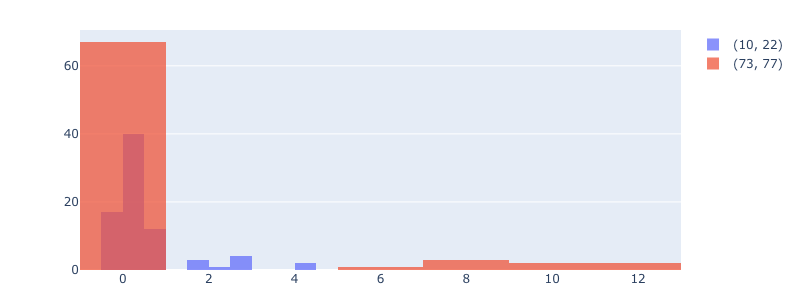

In [56]:
# For example, to compare single window combinations using a histogram
WCOMB1 = (10, 22)
WCOMB2 = (73, 77)

# Get index of each window in strat_cube
fast1_idx = np.where(wrange == WCOMB1[0])[0][0]
slow1_idx = np.where(wrange == WCOMB1[1])[0][0]
fast2_idx = np.where(wrange == WCOMB2[0])[0][0]
slow2_idx = np.where(wrange == WCOMB2[1])[0][0]

print(fast1_idx, slow1_idx, fast2_idx, slow2_idx)

strat_comb1 = strat_cube[:, fast1_idx, slow1_idx]
strat_comb2 = strat_cube[:, fast2_idx, slow2_idx]

vbt.Histogram(
    [str(WCOMB1), str(WCOMB2)], 
    np.vstack((strat_comb1, strat_comb2))
).show_png()

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice



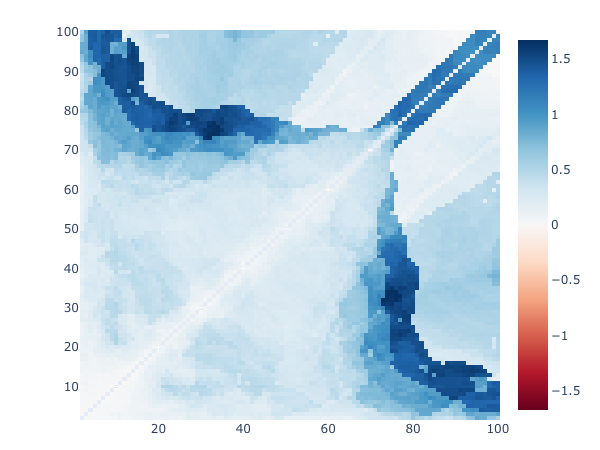

In [57]:
# Or for example, get mean performance for each window combination over all date ranges
vbt.Heatmap(
    wrange, wrange, 
    data=np.nanmean(strat_cube, axis=0),
    heatmap_kwargs=dict(zmid=0, colorscale='RdBu'), 
    figsize=(600, 450)).show_png()

This image alone tells much more than the net profit heatmaps we plotted above!

Now the fun part.

Is our DMAC strategy really better than a simple random or hold strategy? To make any conclusions, we need to perform multiple tests over multiple time ranges (similar to how we compared window combinations earlier). And to make this experiment fair, all strategies must have the same number of tests. Moreover, the random strategy must have the same number of entry and exit signals as in our DMAC strategy.

In [58]:
%%time
# Hold strategy
# Entry at the beginning, no exit
hold_entries_roll_comb = vbt.Signals.falses_like(entries_roll_comb)
hold_entries_roll_comb[0, :] = True
hold_exits_roll_comb = vbt.Signals.falses_like(exits_roll_comb)

hold_roll_comb = metric_roll_comb_from_signals(hold_entries_roll_comb, hold_exits_roll_comb, METRIC)

print(hold_roll_comb.shape)

(383229,)
CPU times: user 13.3 s, sys: 23.6 s, total: 36.9 s
Wall time: 59.4 s


In [59]:
%%time
# Random strategy
# Shuffle entries to get random entry signals of the same shape and cardinality
rand_entries_roll_comb = entries_roll_comb.shuffle(seed=SEED)

# Must have the same number of signals
np.testing.assert_array_equal(rand_entries_roll_comb.sum(axis=0), entries_roll_comb.sum(axis=0))

# If we generate exits the same way as entries, we will get multiple exits between entries
# This is the correct way to generate ONLY ONE exit between two entries
rand_exits_roll_comb = rand_entries_roll_comb.generate_random_exits(seed=SEED)

rand_roll_comb = metric_roll_comb_from_signals(rand_entries_roll_comb, rand_exits_roll_comb, METRIC)

print(rand_roll_comb.shape)

(383229,)
CPU times: user 19.3 s, sys: 31.1 s, total: 50.4 s
Wall time: 1min 13s


In [60]:
np.nanmean(strat_roll_comb), np.nanmean(hold_roll_comb), np.nanmean(rand_roll_comb)

(0.4905312045599127, 1.8080336581293341, 0.15207907777602164)

Hold strategy seems to outperform both other strategies.

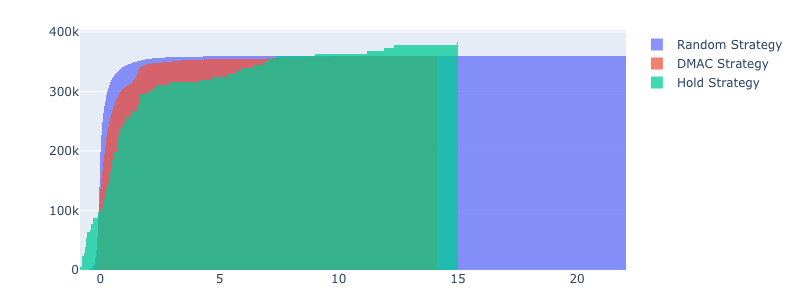

In [61]:
vbt.Histogram(
    ['Random Strategy', 'DMAC Strategy', 'Hold Strategy'], 
    np.vstack((rand_roll_comb, strat_roll_comb, hold_roll_comb)), 
    histogram_kwargs=dict(cumulative_enabled=True)
).show_png()

In particular, Hold strategy seems to outperform both other strategies for positive APPT values (the lower the curve is the better).

To get more insights, we should compare them over time.

In [63]:
# Get start dates of each time range
range_start_idxs = vbt.TimeSeries(np.arange(ohlcv_buf.open.shape[0]).astype(float))
range_start_idxs = vbt.TimeSeries.from_rolling_window(range_start_idxs, (TS_WINDOW + BUFFER).days, step=TS_STEP)
range_start_idxs = range_start_idxs[BUFFER.days, :] # first index after buffer is our start date
range_start_idxs = range_start_idxs.astype(int)
range_end_idxs = range_start_idxs + TS_WINDOW.days

assert(len(range_start_idxs) == nranges)

In [64]:
# Get the average performance for each time range and strategy
strat_range_mean = np.nanmean(strat_cube, axis=(1, 2))

hold_cube = unstack_roll_comb(hold_roll_comb)
hold_range_mean = np.nanmean(hold_cube, axis=(1, 2))

rand_cube = unstack_roll_comb(rand_roll_comb)
rand_range_mean = np.nanmean(rand_cube, axis=(1, 2))

print(strat_range_mean.shape, hold_range_mean.shape, rand_range_mean.shape)

(79,) (79,) (79,)


In [65]:
# Get the average performance for each date and strategy
strat_date_mean = np.full((ohlcv.open.shape[0], strat_range_mean.shape[0]), np.nan)
hold_date_mean = np.full_like(strat_date_mean, np.nan)
rand_date_mean = np.full_like(strat_date_mean, np.nan)
for i in range(strat_range_mean.shape[0]):
    strat_date_mean[range_start_idxs[i]:range_end_idxs[i], i] = strat_range_mean[i]
    hold_date_mean[range_start_idxs[i]:range_end_idxs[i], i] = hold_range_mean[i]
    rand_date_mean[range_start_idxs[i]:range_end_idxs[i], i] = rand_range_mean[i]

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

Mean of empty slice

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice



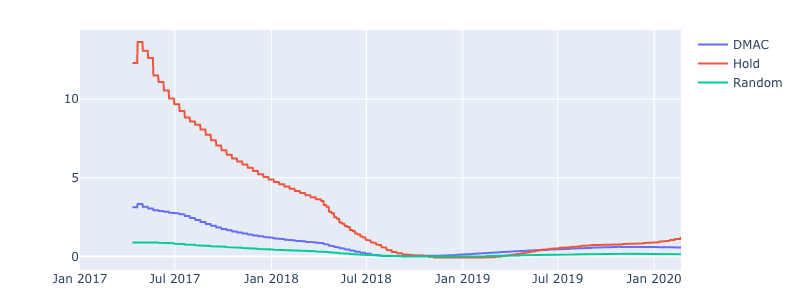

In [66]:
vbt.Scatter(['DMAC', 'Hold', 'Random'], df.index, data=np.vstack((
    np.nanmean(strat_date_mean, axis=1),
    np.nanmean(hold_date_mean, axis=1),
    np.nanmean(rand_date_mean, axis=1)
))).show_png()

The Random strategy is the weakest strategy, the DMAC strategy shines in downtrends, and the Hold strategy excells in uptrends. The DMAC strategy seems to be a good fit for "roller coaster" markets such as the cryptocurrency market.

TL;DR: HODL your Bitcoins!

In [67]:
# You can go further and plot the above graph for each window combination

def strat_date_mean_of_windows(fast_window, slow_window):
    """Get the average performance for each date and window combination."""
    fast_idx = np.where(wrange == fast_window)[0][0]
    slow_idx = np.where(wrange == slow_window)[0][0]
    strat_comb_date_mean = np.full((ohlcv.open.shape[0], strat_range_mean.shape[0]), np.nan)
    for i in range(strat_range_mean.shape[0]):
        strat_comb_date_mean[range_start_idxs[i]:range_end_idxs[i], i] = strat_cube[i, fast_idx, slow_idx]
    return strat_comb_date_mean

windows_slider = widgets.IntRangeSlider(
    value=[20, 80],
    min=MIN_WINDOW,
    max=MAX_WINDOW,
    step=1,
    layout=dict(width='500px'),
    continuous_update=True
)

scatter_fig = vbt.Scatter(['DMAC', 'Hold', 'Random'], df.index)
scatter_img = widgets.Image(
    format='png',
    width=scatter_fig.layout.width,
    height=scatter_fig.layout.height
)

def on_value_change(value):
    fast_window, slow_window = value['new']
    strat_date_mean = strat_date_mean_of_windows(fast_window, slow_window)
    scatter_fig.update_data(np.vstack((
        np.nanmean(strat_date_mean, axis=1),
        np.nanmean(hold_date_mean, axis=1),
        np.nanmean(rand_date_mean, axis=1)
    )))
    scatter_img.value = scatter_fig.to_image(format="png")
    
windows_slider.observe(on_value_change, names='value')
on_value_change({'new': windows_slider.value}) # default range

widgets.VBox([
    widgets.HBox([
        widgets.Label('Fast and slow window:'), 
        windows_slider
    ]), 
    scatter_img
])

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning:

Mean of empty slice

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning:

Mean of empty slice

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice



Big windows for bullish markets (effect similar to holding), small windows for bearish markets (fast exit -> loss minimization).

In [68]:
widgets.Widget.close_all() # after using, release memory and notebook metadata

In [69]:
import gc

gc.collect()

66157